In [1]:
## Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

# Load in database
database = pd.read_hdf(r"C:\dev\2408_SU24_F31\processed\database.h5")

In [79]:
## GLOBAL VARIABLES
subject = 'sub-SB03'
session = 'ses-04'
roi_id = 10

In [80]:
## SESSION SUMMARY


n_rois = sum(database.raw.cell_identifier.loc[subject, session][:,0] == True) # select just the first column containing booleans

print(f"Subject {subject} Session {session} has {n_rois} ROIs")

Subject sub-SB03 Session ses-04 has 108 ROIs


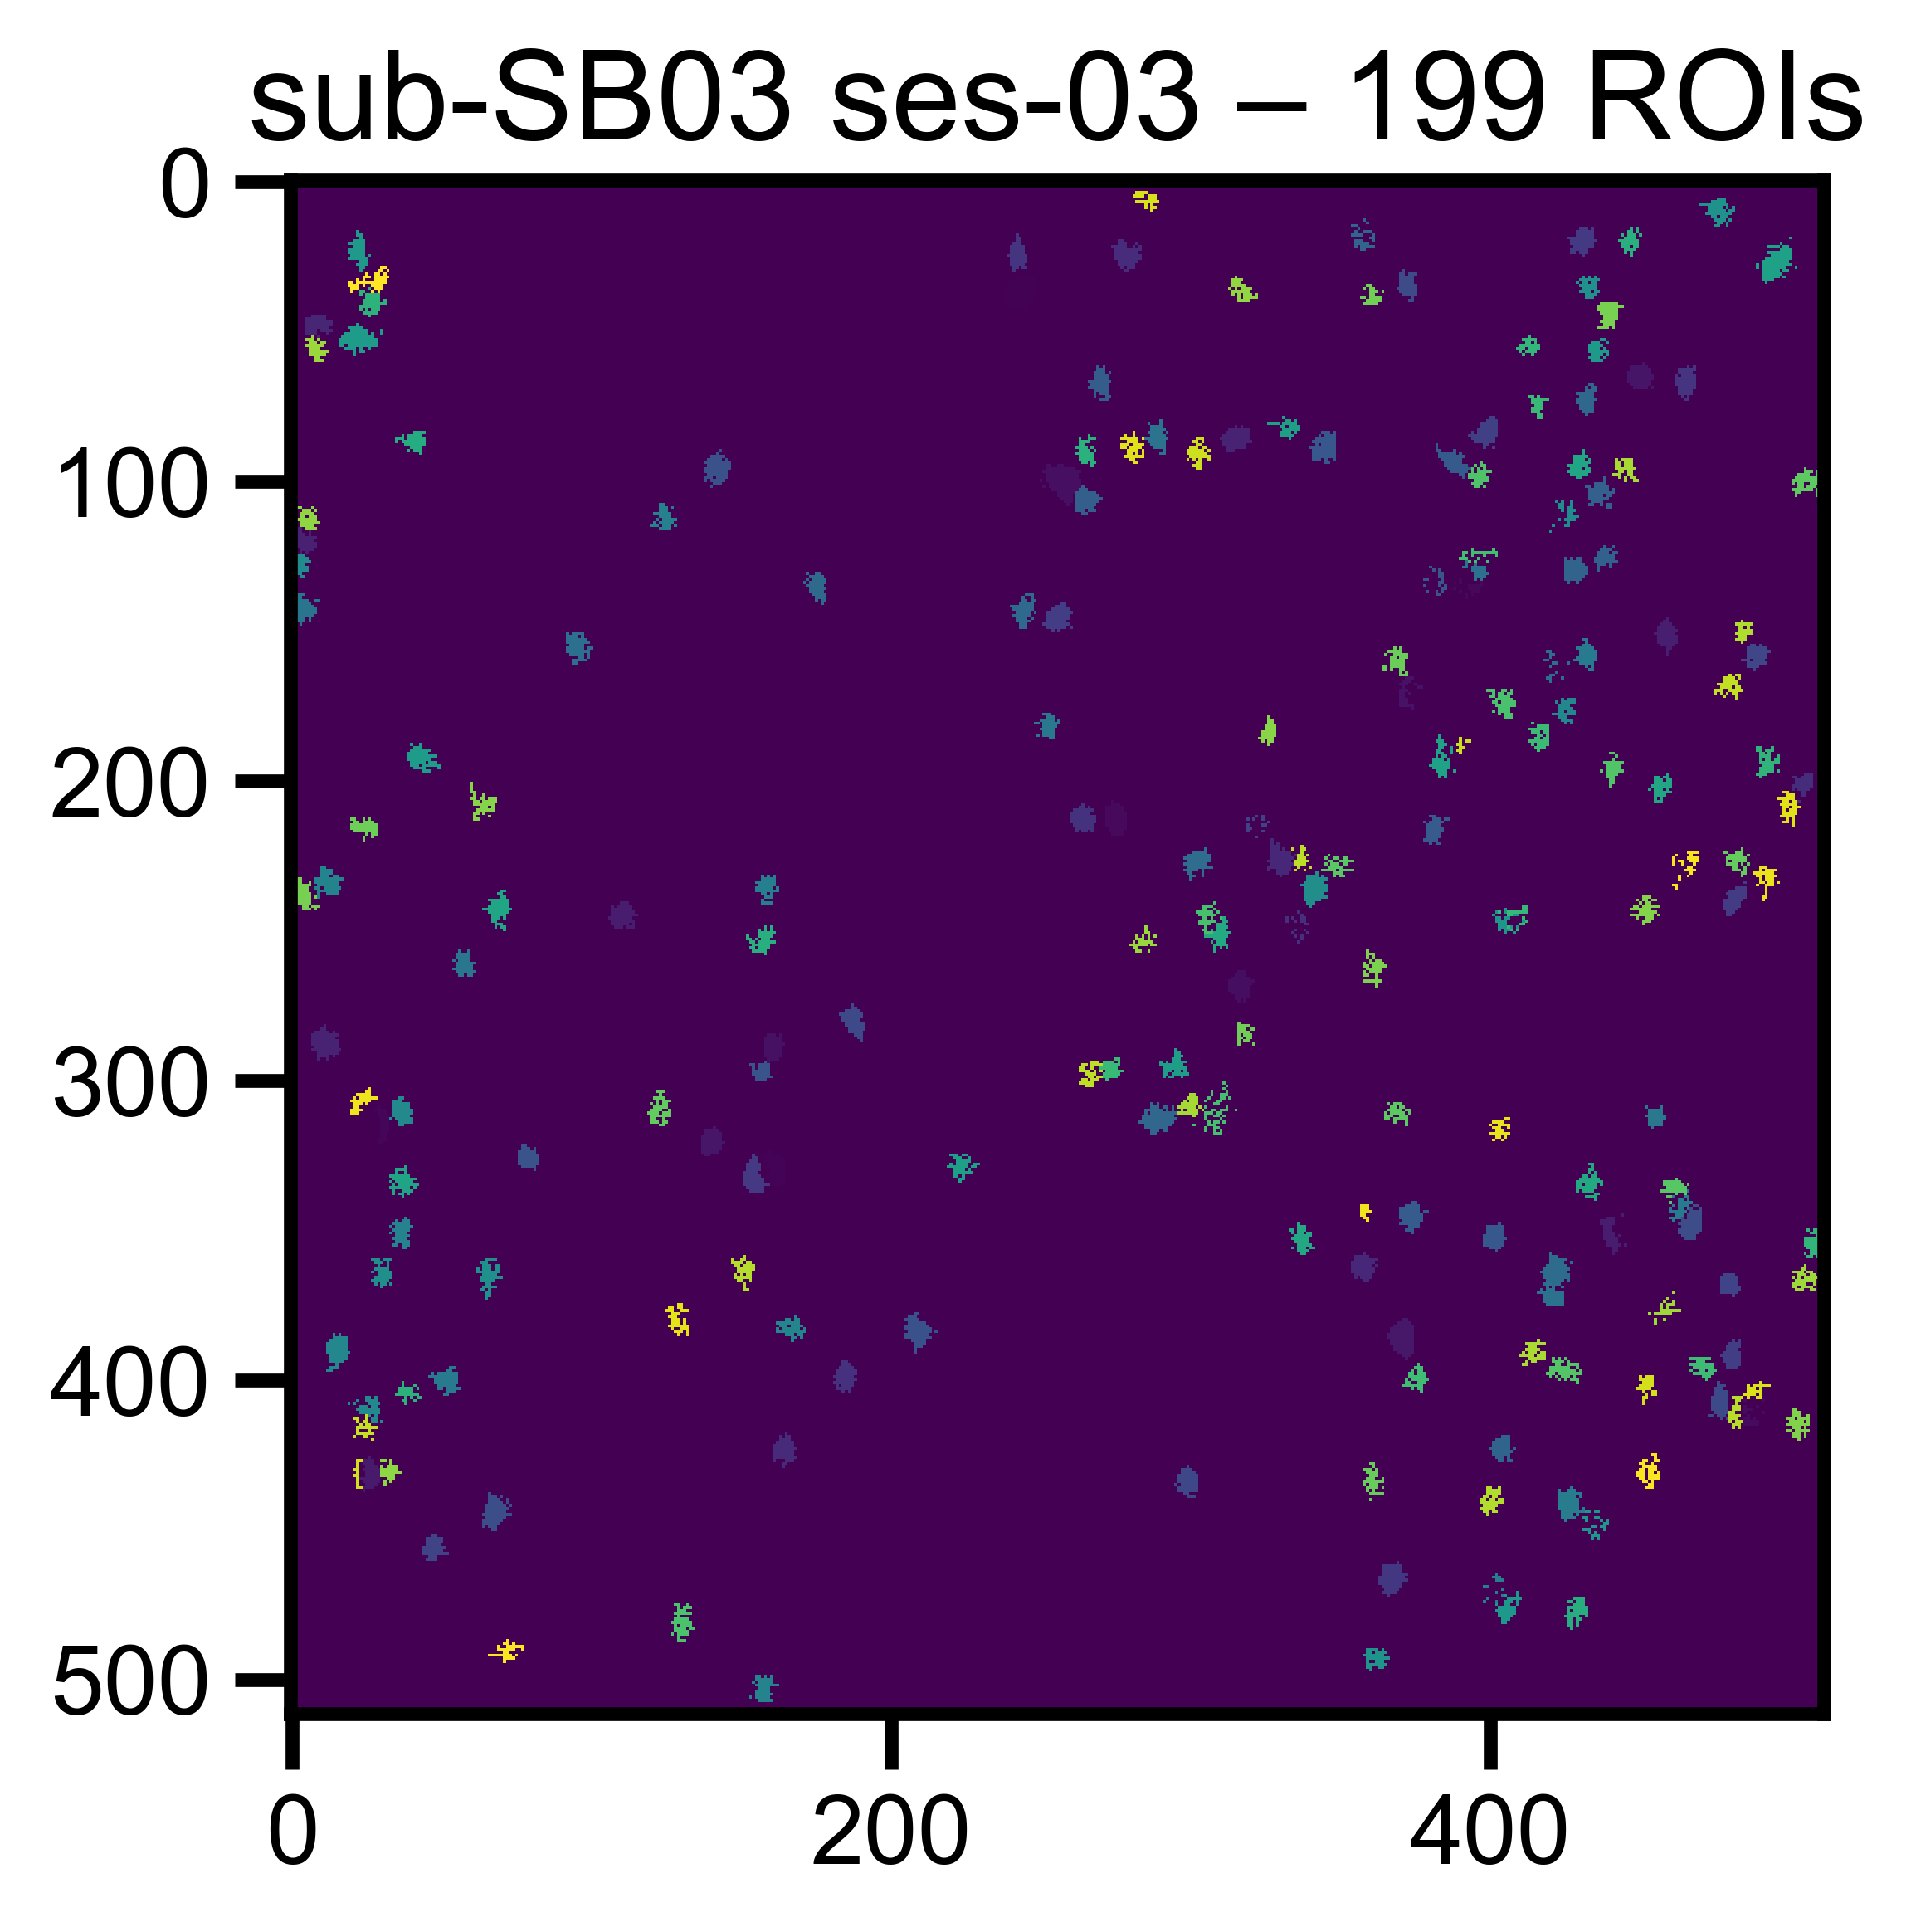

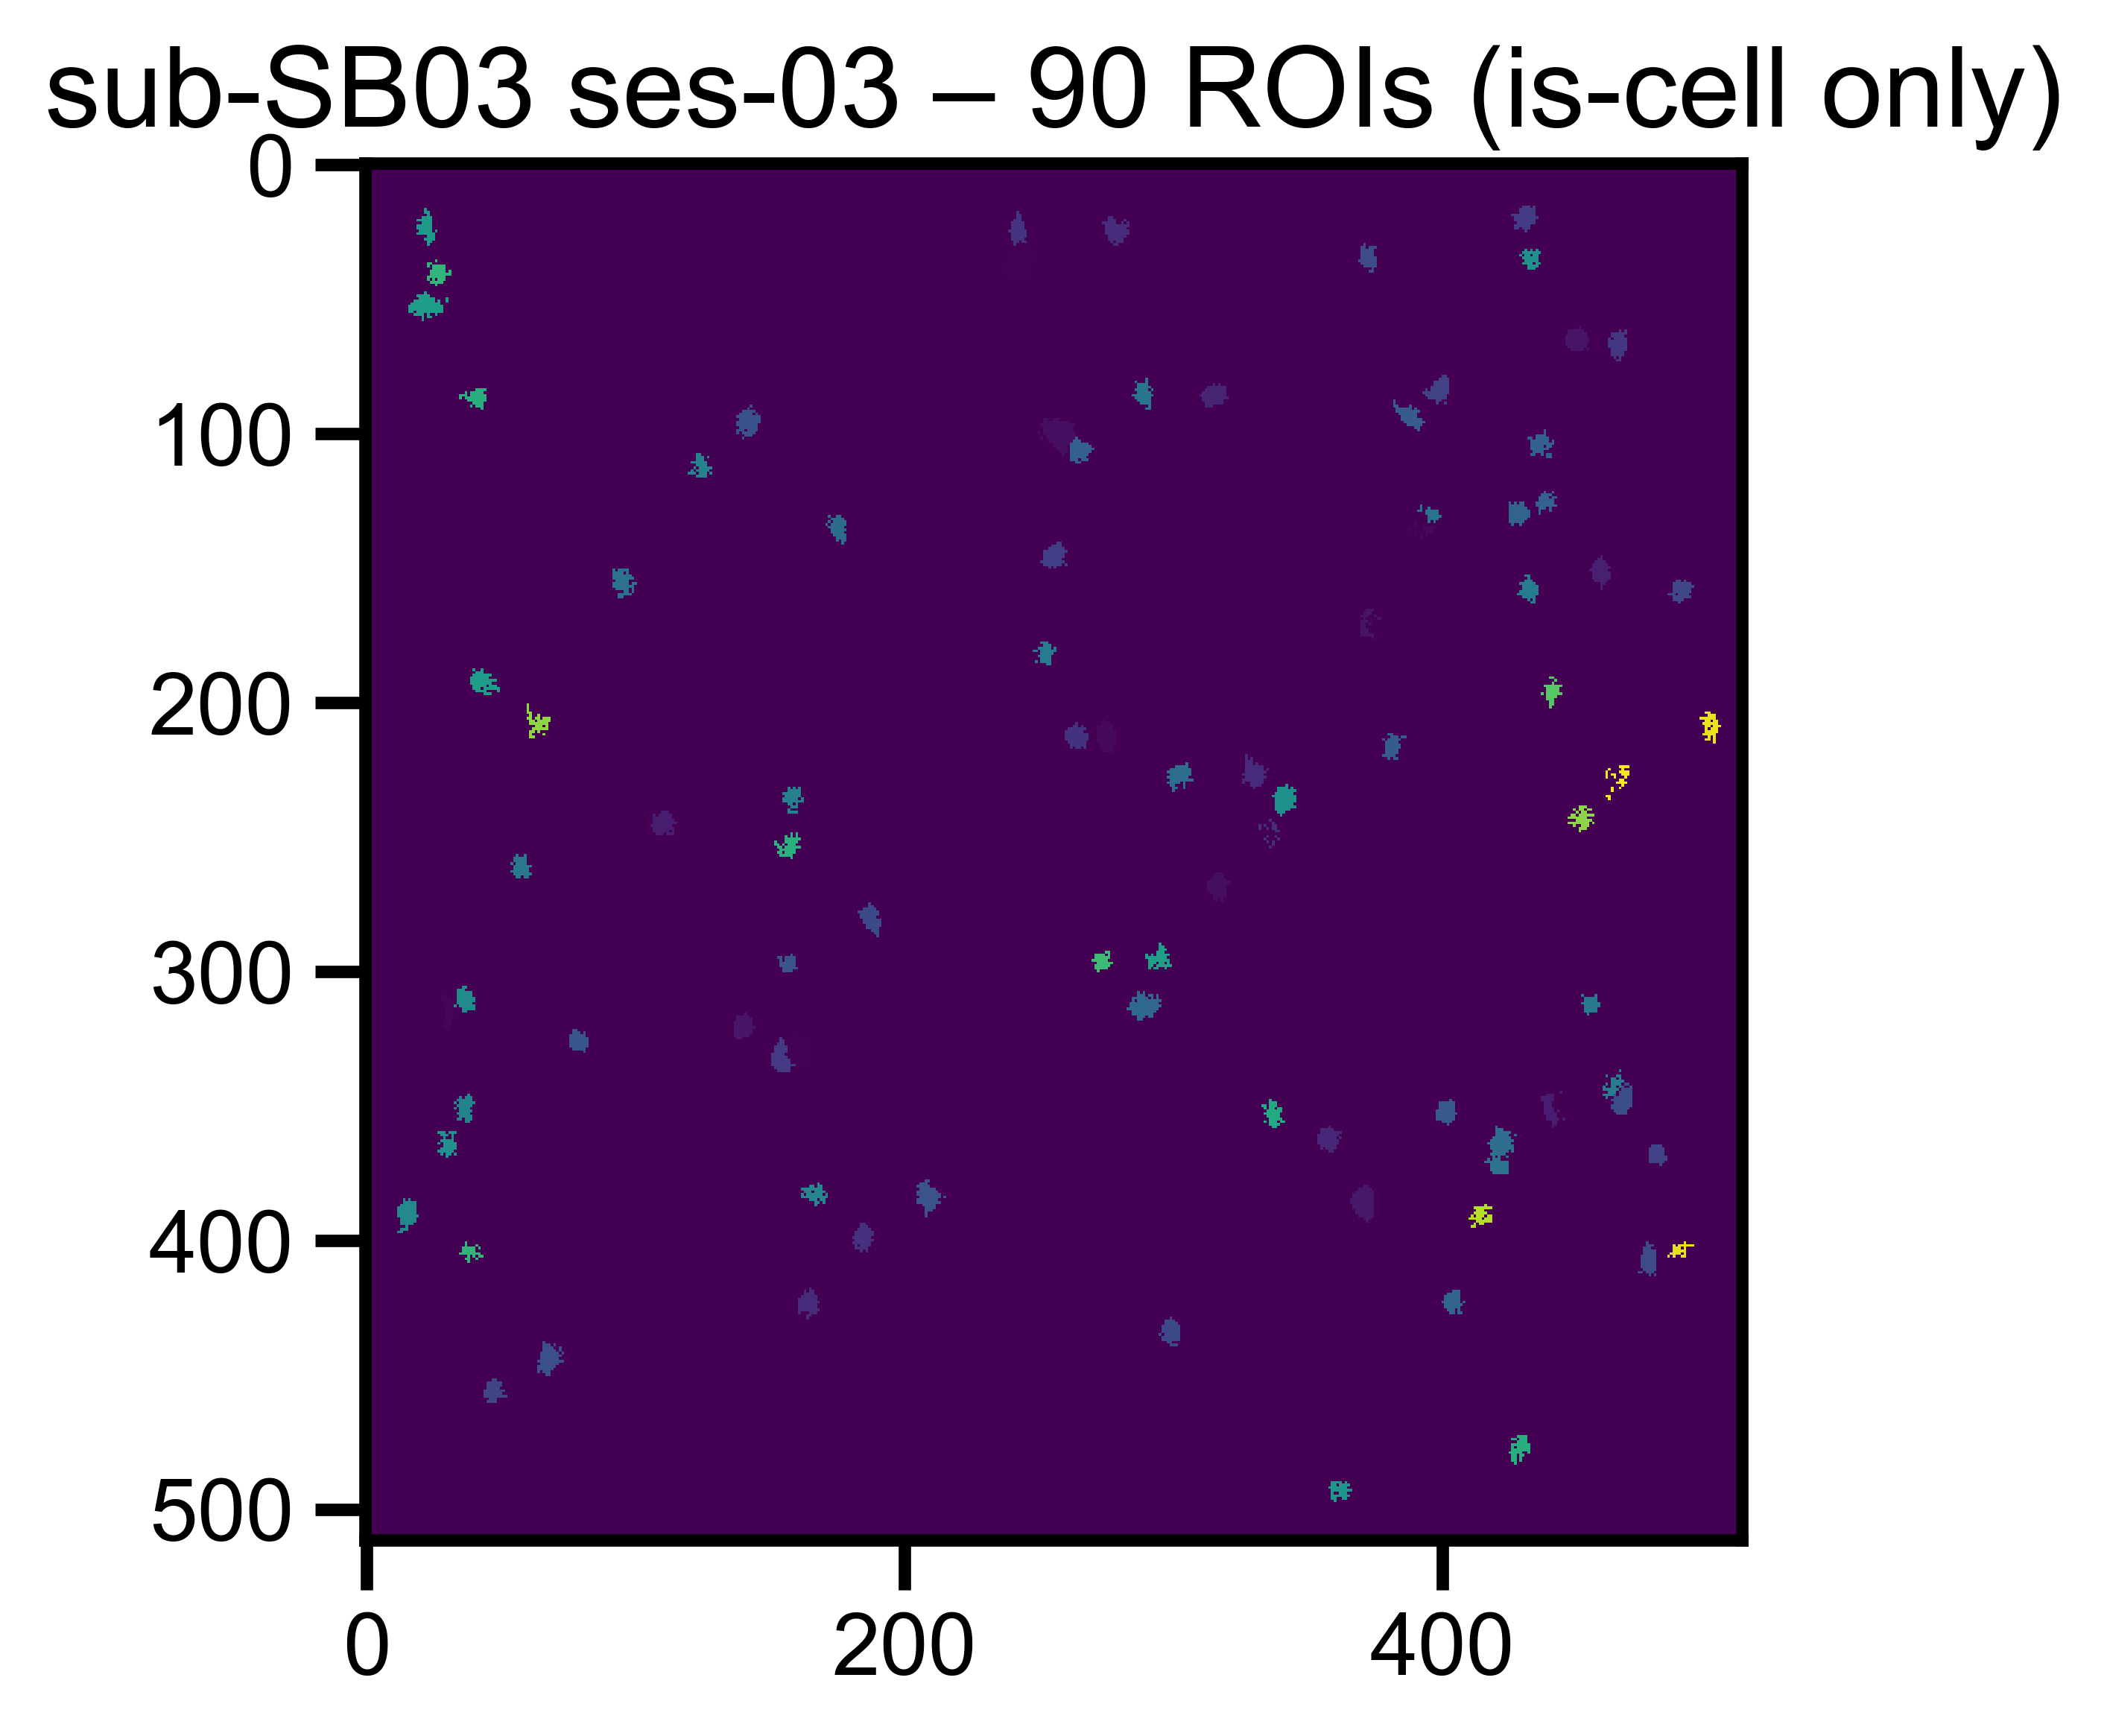

(<Figure size 4800x2400 with 1 Axes>,
 <Axes: title={'center': 'sub-SB03 ses-03 – 90 ROIs (is-cell only)'}>)

In [68]:
## SHOW ROIS IN FOV


def plot_session_rois(database, subject, session, roi_indices=None, title_suffix=None):

    """
    Plot a single image containing ROIs for the specified subject/session,
    matching the original style (imshow + title + show).

    Parameters:
      database     : main DataFrame with raw.stat, raw.ops, raw.cell_identifier
      subject      : subject id (e.g., 'sub-SB03')
      session      : session id (e.g., 'ses-02')
      roi_indices  : optional iterable of ROI indices to include; if None, include all
      title_suffix : optional string appended to the title (e.g., "valid-only")

    Title format: "<subject> <session> – <n_selected> ROIs" (+ optional suffix)

    Returns:
      fig, ax : Matplotlib figure and axes
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Try to index stat/ops directly by (subject, session)
    try:
        stat_p = database.raw.stat.loc[subject, session]
        ops_p = database.raw.ops.loc[subject, session]
    except Exception:
        # Fallback to prior behavior if stat/ops are not MultiIndexed
        stat = database.raw.stat
        ops = database.raw.ops
        if isinstance(ops, dict):
            stat_p = stat
            ops_p = ops
        else:
            # If multiple sessions are present but we cannot select by index here,
            # fall back to the first entry (assumption based on available context).
            stat_p = stat[0]
            ops_p = ops[0]

    # Determine which ROIs to include
    n_all = len(stat_p)
    if roi_indices is None:
        roi_indices = range(n_all)
    else:
        # ensure it's a simple list/array of ints
        roi_indices = list(roi_indices)

    # Build one image that includes selected ROIs
    Ly, Lx = ops_p['Ly'], ops_p['Lx']
    im = np.zeros((Ly, Lx))
    for n in roi_indices:
        ypix = stat_p[n]['ypix']
        xpix = stat_p[n]['xpix']
        # Respect overlap mask if present; otherwise assume none are overlapping
        overlap = stat_p[n].get('overlap', None)
        if overlap is not None:
            ypix = ypix[~overlap]
            xpix = xpix[~overlap]
        im[ypix, xpix] = n + 1

    fig, ax = plt.subplots()
    ax.imshow(im)
    n_selected = len(roi_indices)
    title = f"{subject} {session} – {n_selected} ROIs"
    if title_suffix:
        title = f"{title} ({title_suffix})"
    ax.set_title(title)
    plt.show()
    return fig, ax

def plot_session_rois_valid(database, subject, session):

    """Convenience wrapper: plot only ROIs where ('raw','cell_identifier') first column is True."""

    valid_mask = database.raw.cell_identifier.loc[subject, session][:, 0]
    roi_idx = np.where(valid_mask)[0]
    return plot_session_rois(database, subject, session, roi_indices=roi_idx, title_suffix="is-cell only")

plot_session_rois(database, subject, session)             # all ROIs
plot_session_rois_valid(database, subject, session)       # valid-only ROIs

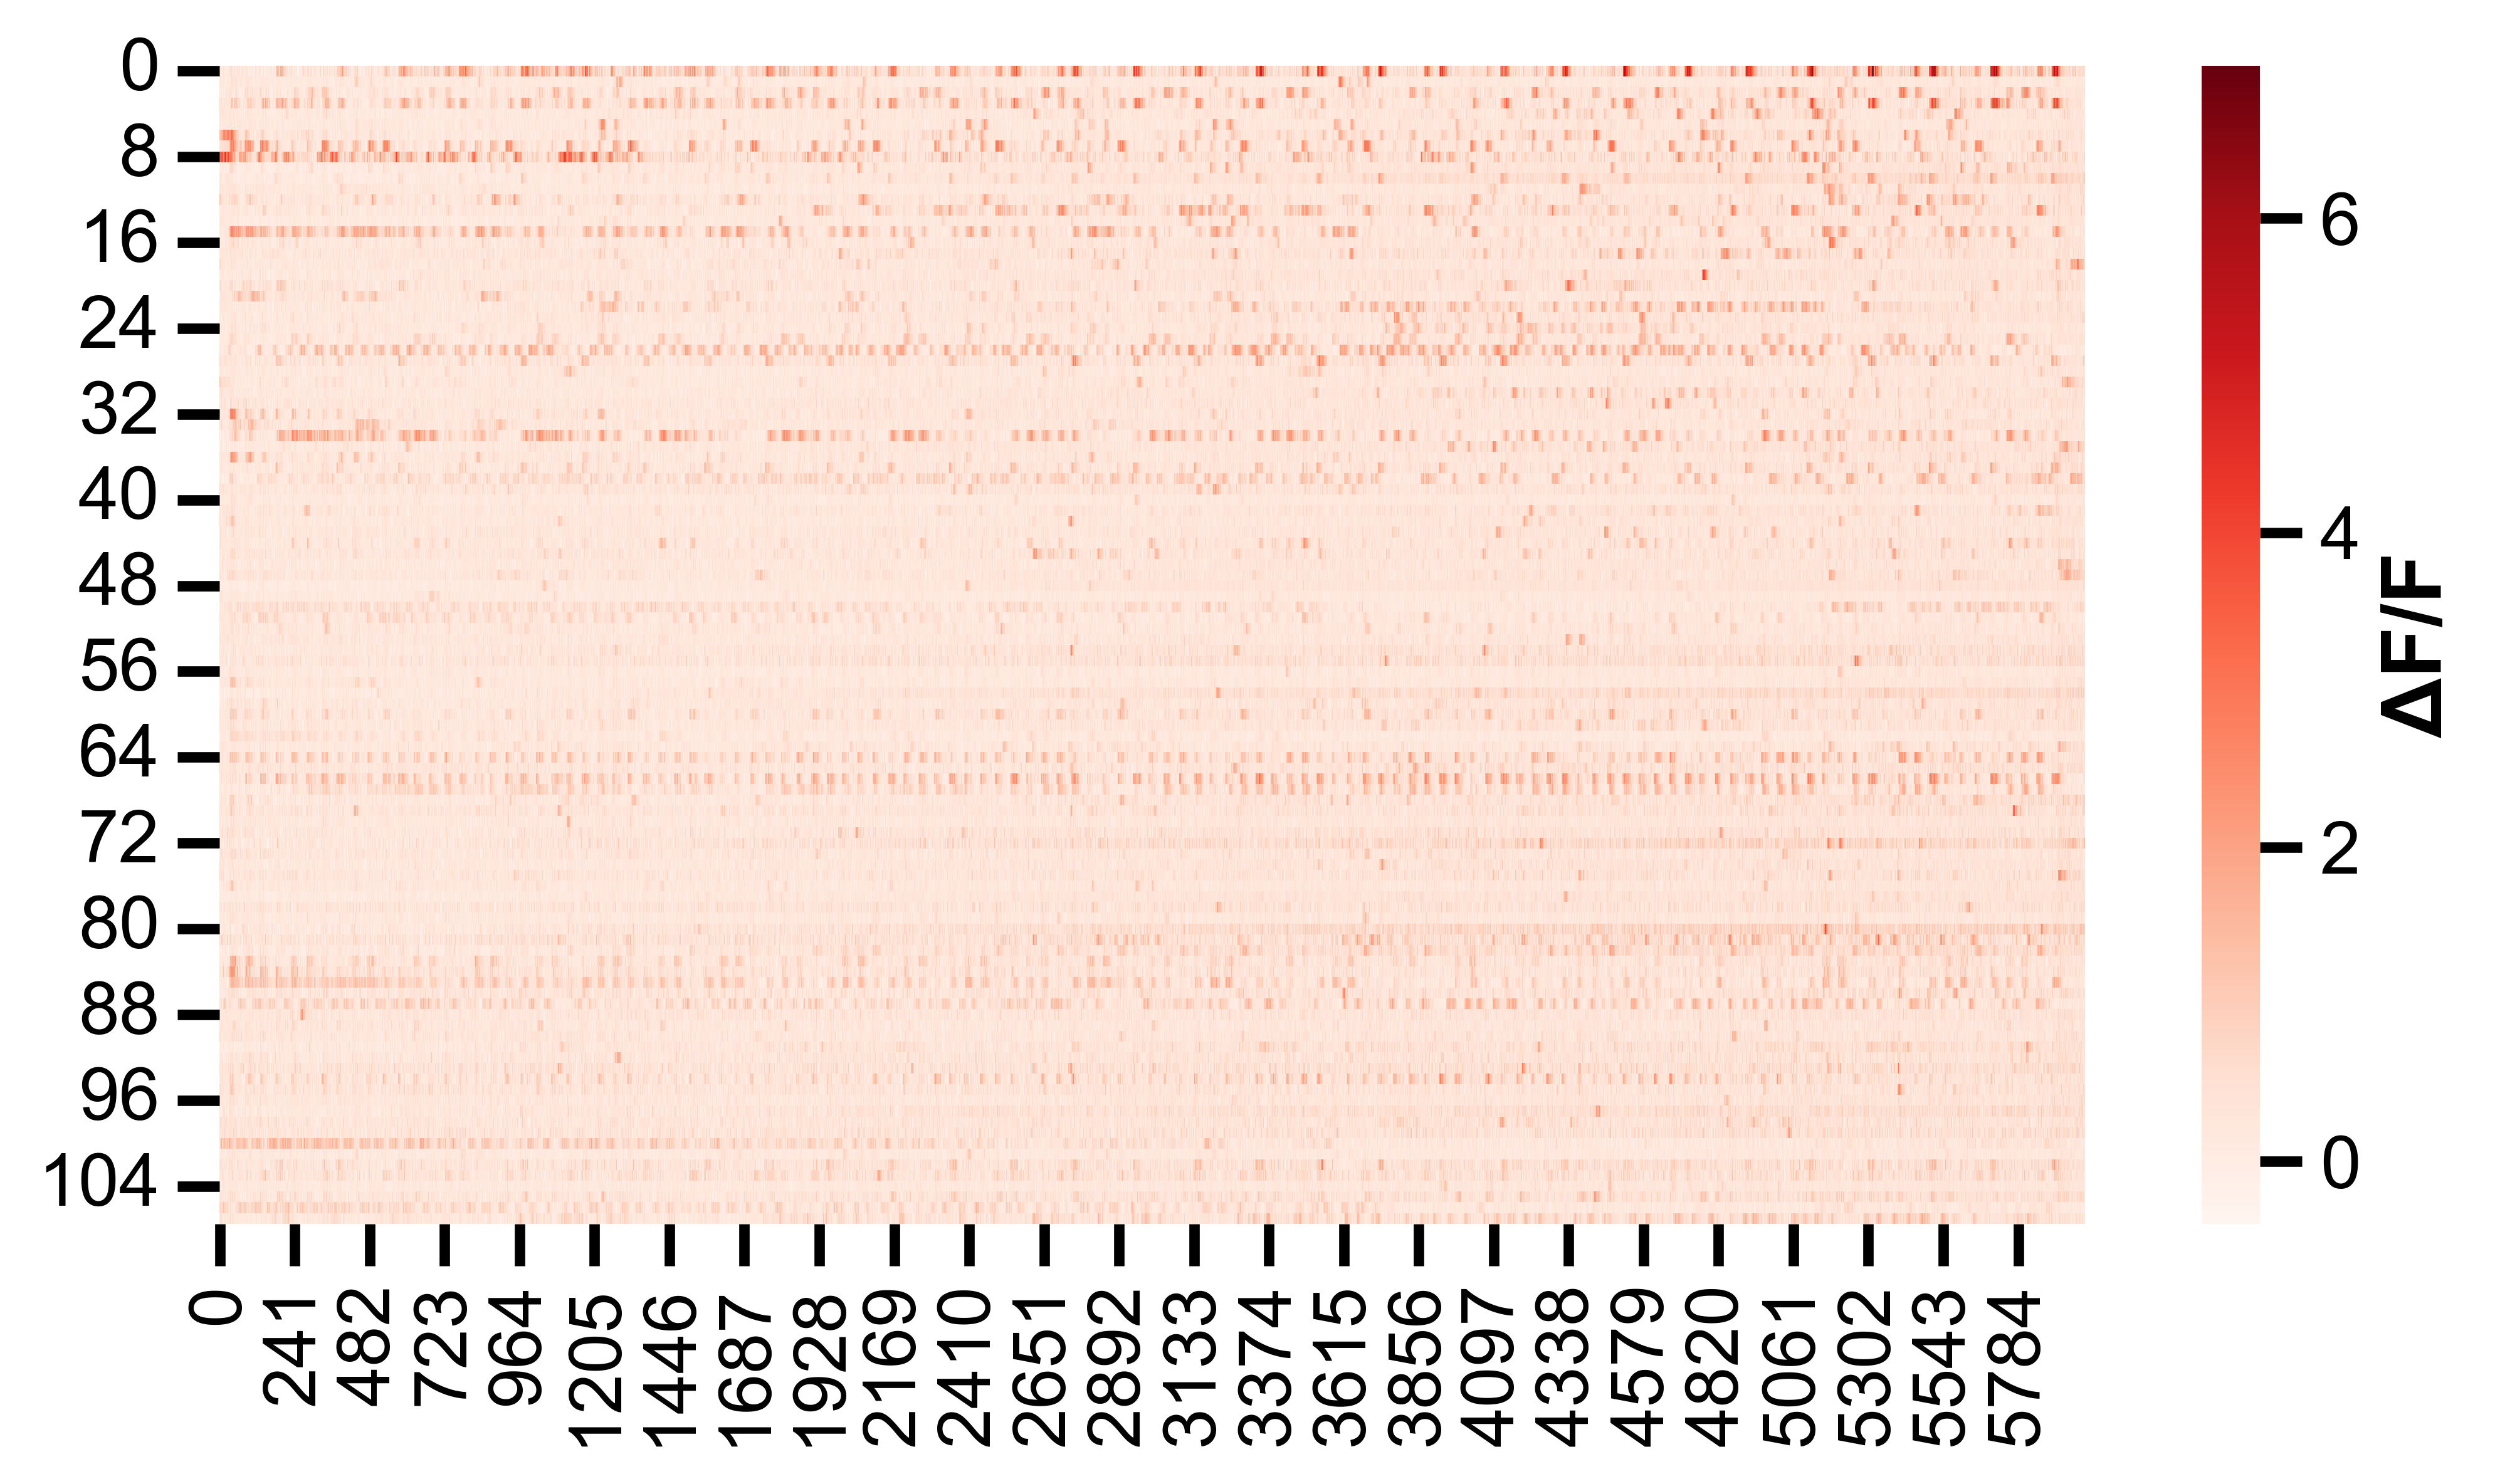

In [81]:
## ACTIVITY HEATMAP

sns.heatmap(database.calculate.deltaf_f.loc[subject, session], cmap='Reds', cbar_kws={'label': 'ΔF/F'})
plt.show()

(<Figure size 4800x2400 with 1 Axes>,
 <Axes: title={'center': 'sub-SB03 ses-04 – ROI 10'}, xlabel='Time (s)', ylabel='ΔF/F'>)

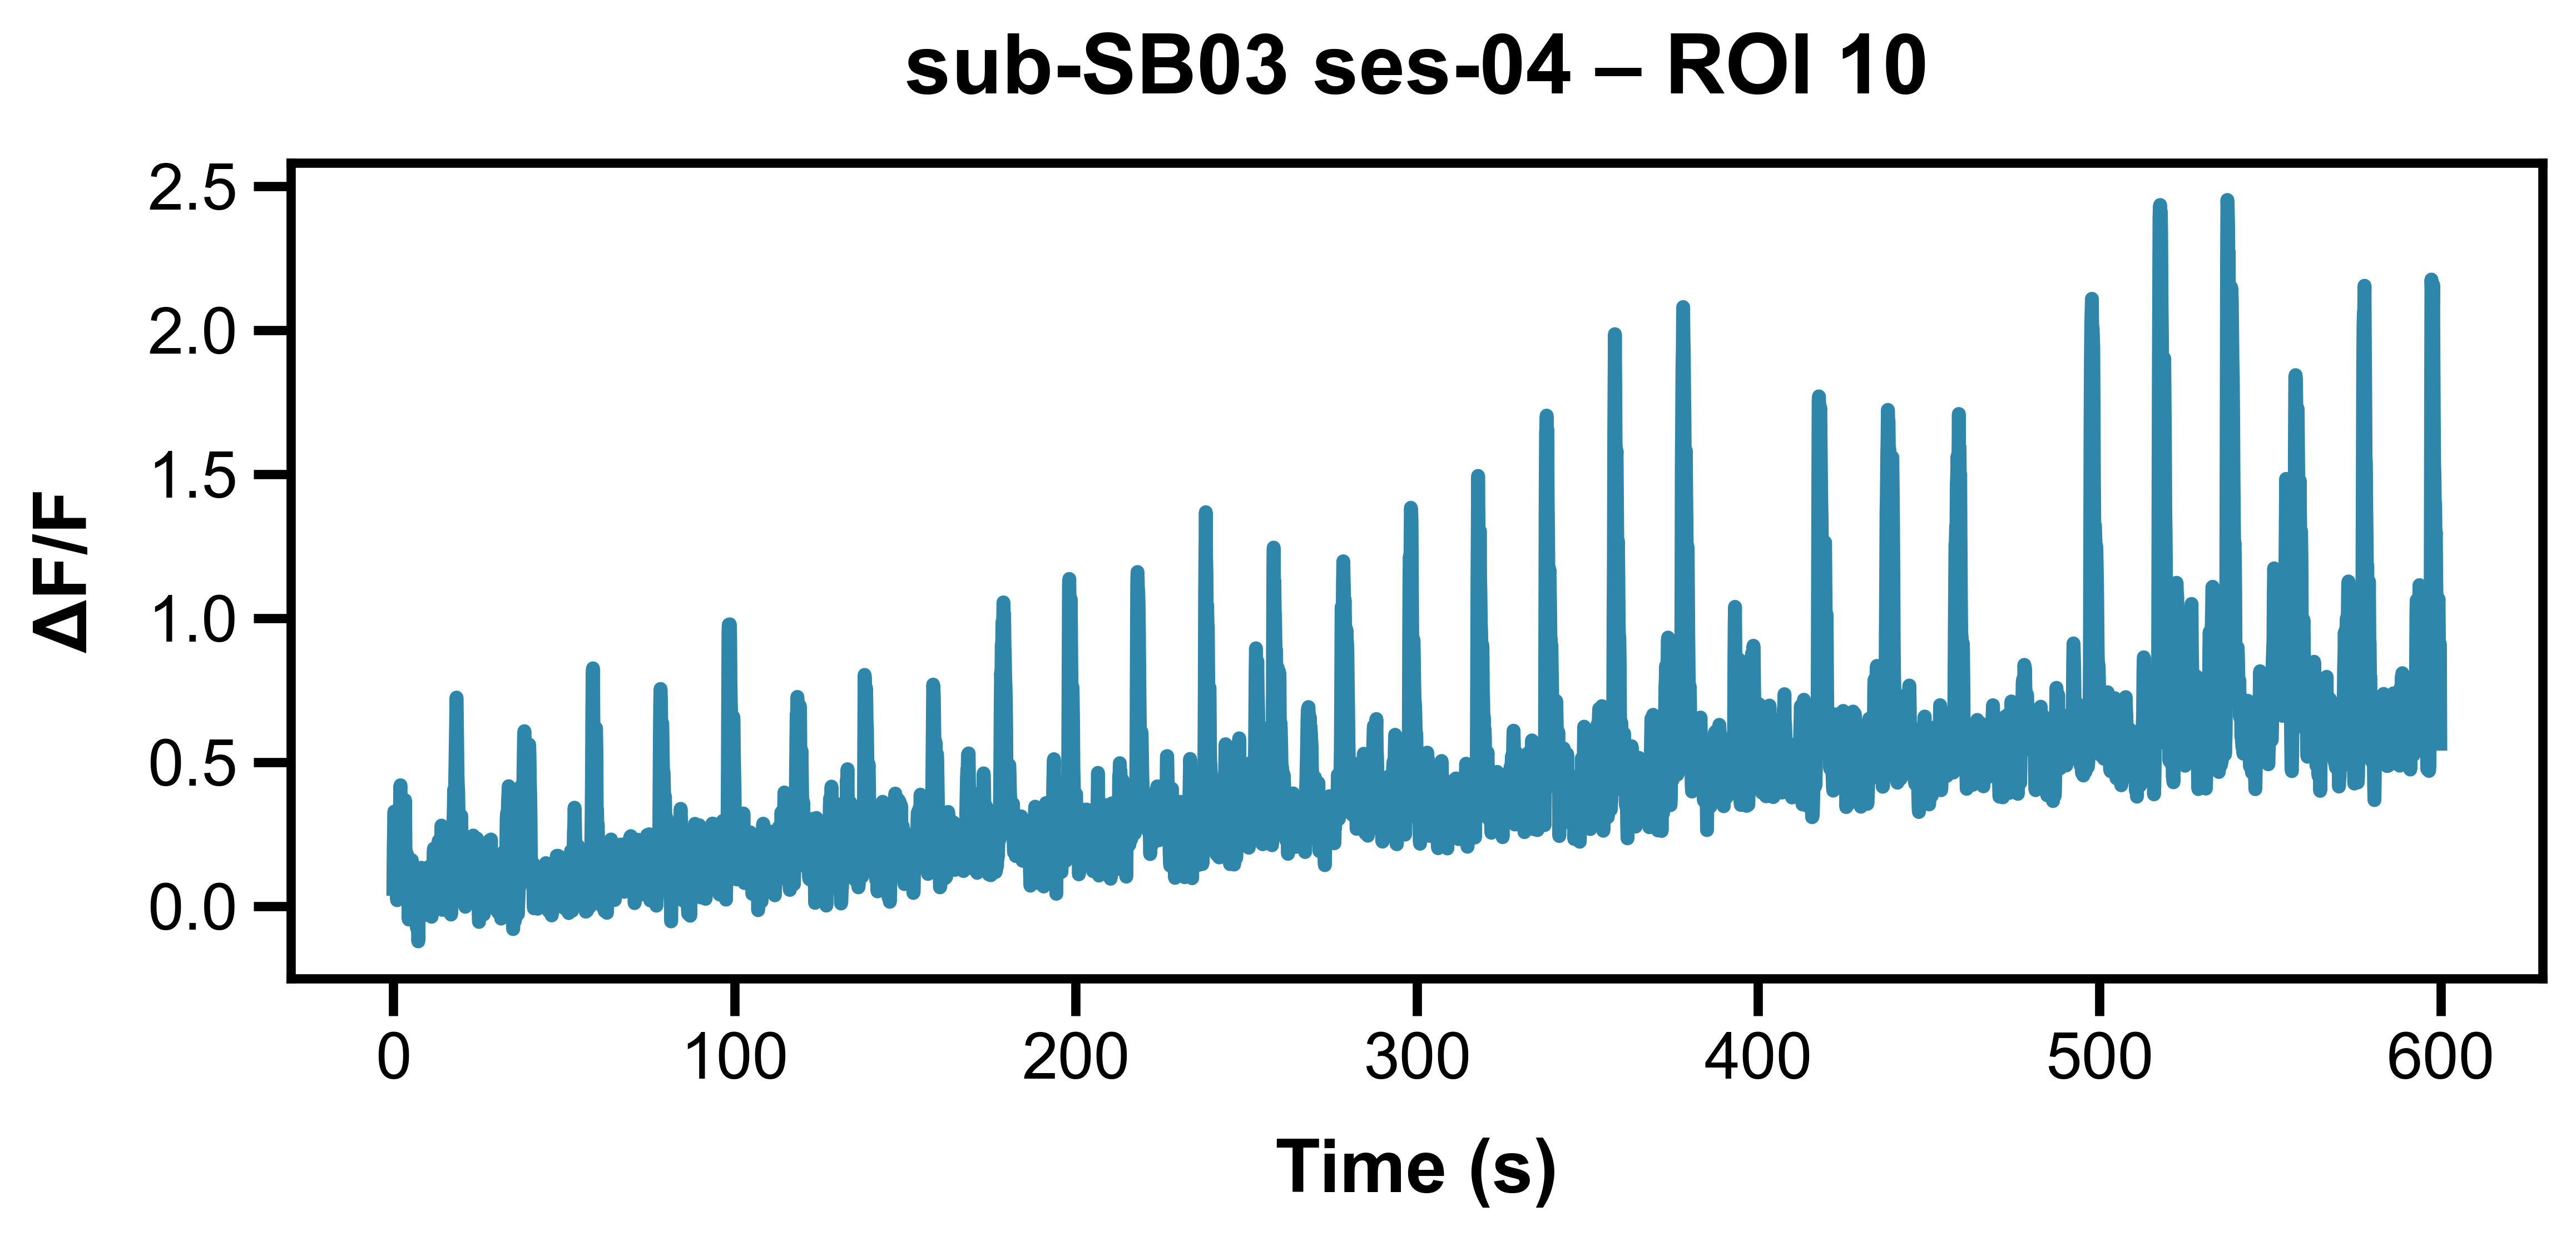

In [82]:
## PLOT DFF TRACE


def roi_dff(database, subject, session, roi_idx, num_points=6000):
    """
    Create a poster-quality ΔF/F trace for one ROI.
    
    Args:
      database   : main DataFrame
      subject    : e.g. 'sub-SB03'
      session    : e.g. 'ses-01'
      roi_idx    : ROI index (e.g. 61)
      num_points : number of frames to plot (default: 1000)
    
    Returns:
      fig, ax : Matplotlib figure and axes
    """
    import matplotlib.pyplot as plt
    # extract data
    times = database.toolkit.timestamps.loc[subject, session].values[:num_points]
    trace = database.calculate.smoothed_dff.loc[subject, session][roi_idx][:num_points]

    # poster styling
    plt.rcParams.update({
        'figure.figsize': (8, 4),
        'figure.dpi': 600,
        'font.size': 16,
        'font.family': 'Arial',
        'axes.linewidth': 2,
        'axes.labelweight': 'bold',
        'axes.titlesize': 18,
        'xtick.major.size': 8,
        'xtick.major.width': 2,
        'ytick.major.size': 8,
        'ytick.major.width': 2,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
    })

    fig, ax = plt.subplots()
    ax.plot(times, trace, color='#2E86AB', linewidth=3)

    # labels & title
    ax.set_xlabel('Time (s)', labelpad=10, weight='bold')
    ax.set_ylabel('ΔF/F', labelpad=10, weight='bold')
    ax.set_title(f'{subject} {session} – ROI {roi_idx}', pad=15, weight='bold')

    # thicken spines
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    plt.tight_layout()
    return fig, ax

roi_dff(database, subject, session, roi_id)

In [83]:
## TUNING, OSI/DSI VECTOR


trials = database.toolkit.trials.loc[subject, session]
dff_on = trials['dff_on'].to_numpy()  # list-like of length n_trials; each: (n_rois, n_time)
dff_off = trials['dff_off'].to_numpy()  # list-like of length n_trials; each: (n_rois, n_time)

# calculate per-trial mean dF/F for a ROI
def mean_dff_per_trial(dff_trials, roi_id):
    trial_means = np.array([np.mean(trial[roi_id, :]) for trial in dff_trials])
    orientations = trials['orientation'].to_numpy()
    directions = trials['direction'].to_numpy()
    return pd.DataFrame({'trial_means': trial_means , 'orientations': orientations, 'directions': directions})

on_means = mean_dff_per_trial(dff_on, roi_id)
off_means = mean_dff_per_trial(dff_off, roi_id)

# identify tuned stimuli
def preferred_stimulus(on_means):
    ori = on_means.groupby('orientations')['trial_means']
    dir = on_means.groupby('directions')['trial_means']
    ori_mean = ori.agg(lambda x: x.mean())
    dir_mean = dir.agg(lambda x: x.mean())
    pref_ori = ori_mean.idxmax()
    pref_dir = dir_mean.idxmax()
    return {'ori': {'pref_ori': pref_ori, 'ori_mean': ori_mean}, 'dir': {'pref_dir': pref_dir, 'dir_mean': dir_mean}}

pref_on = pd.DataFrame(preferred_stimulus(on_means))
print(f"Preferred Orientation: {pref_on.ori.pref_ori} Degrees" , pref_on.ori.ori_mean)
print(f"Preferred Direction: {pref_on.dir.pref_dir} Degrees" , pref_on.dir.dir_mean)
# plt.plot(pref_on.dir.dir_mean)
# plt.xticks(pref_on.dir.dir_mean.index)
# plt.show()

def normalize_tuning(tuning_dict):
    ori_mean = tuning_dict['ori']['ori_mean']
    dir_mean = tuning_dict['dir']['dir_mean']
    pref_ori = tuning_dict['ori']['pref_ori']
    pref_dir = tuning_dict['dir']['pref_dir']
    
    # find orthogonal orientation
    orth_ori = (pref_ori + 90) % 180
    norm_ori = (ori_mean[pref_ori] - ori_mean[orth_ori]) / ori_mean[pref_ori] #change to ori_mean[i]/sum(ori_mean)
    osi = np.abs(np.sum(ori_mean*np.exp(2j* pref_ori) / np.sum(ori_mean)))

    # find orthogonal direction
    orth_dir = (pref_dir + 180) % 360
    norm_dir = (dir_mean[pref_dir] - dir_mean[orth_dir]) / dir_mean[pref_dir]
    dsi = np.abs(np.sum(dir_mean*np.exp(1j* pref_dir) / np.sum(dir_mean)))
    
    return {'norm_ori': norm_ori, 'norm_dir': norm_dir, 'osi': osi, 'dsi': dsi}
norm_tuning = normalize_tuning(pref_on)

print(f"Normalized Orientation Tuning: {norm_tuning['norm_ori']}")
print(f"Normalized Direction Tuning: {norm_tuning['norm_dir']}")

def osi_dsi(tuning_dict):
    ori_mean = tuning_dict['ori']['ori_mean']
    dir_mean = tuning_dict['dir']['dir_mean']

    # OSI calculation
    angle_ori = np.deg2rad(ori_mean.index)
    tc_ori = ori_mean.values
    osi = (np.abs(np.sum(tc_ori * np.exp(2j * angle_ori)) / np.sum(tc_ori)))

    # DSI calculation
    angle_dir = np.deg2rad(dir_mean.index)
    tc_dir = dir_mean.values
    dsi = (np.abs(np.sum(tc_dir * np.exp(1j * angle_dir)) / np.sum(tc_dir)))

    return {'osi': osi, 'dsi': dsi}
osi_dsi_values = osi_dsi(pref_on)
print(f"Orientation Selectivity Index (OSI): {osi_dsi_values['osi']}")
print(f"Direction Selectivity Index (DSI): {osi_dsi_values['dsi']}")



Preferred Orientation: 135 Degrees orientations
0      0.376980
45     0.384226
90     0.452130
135    0.918644
Name: trial_means, dtype: float64
Preferred Direction: 135 Degrees directions
0      0.375535
45     0.370232
90     0.423426
135    0.951369
180    0.378425
225    0.398220
270    0.480833
315    0.885920
Name: trial_means, dtype: float64
Normalized Orientation Tuning: 0.5817467123577861
Normalized Direction Tuning: 0.06879463836295817
Orientation Selectivity Index (OSI): 0.25313382512219107
Direction Selectivity Index (DSI): 0.01772386507694638


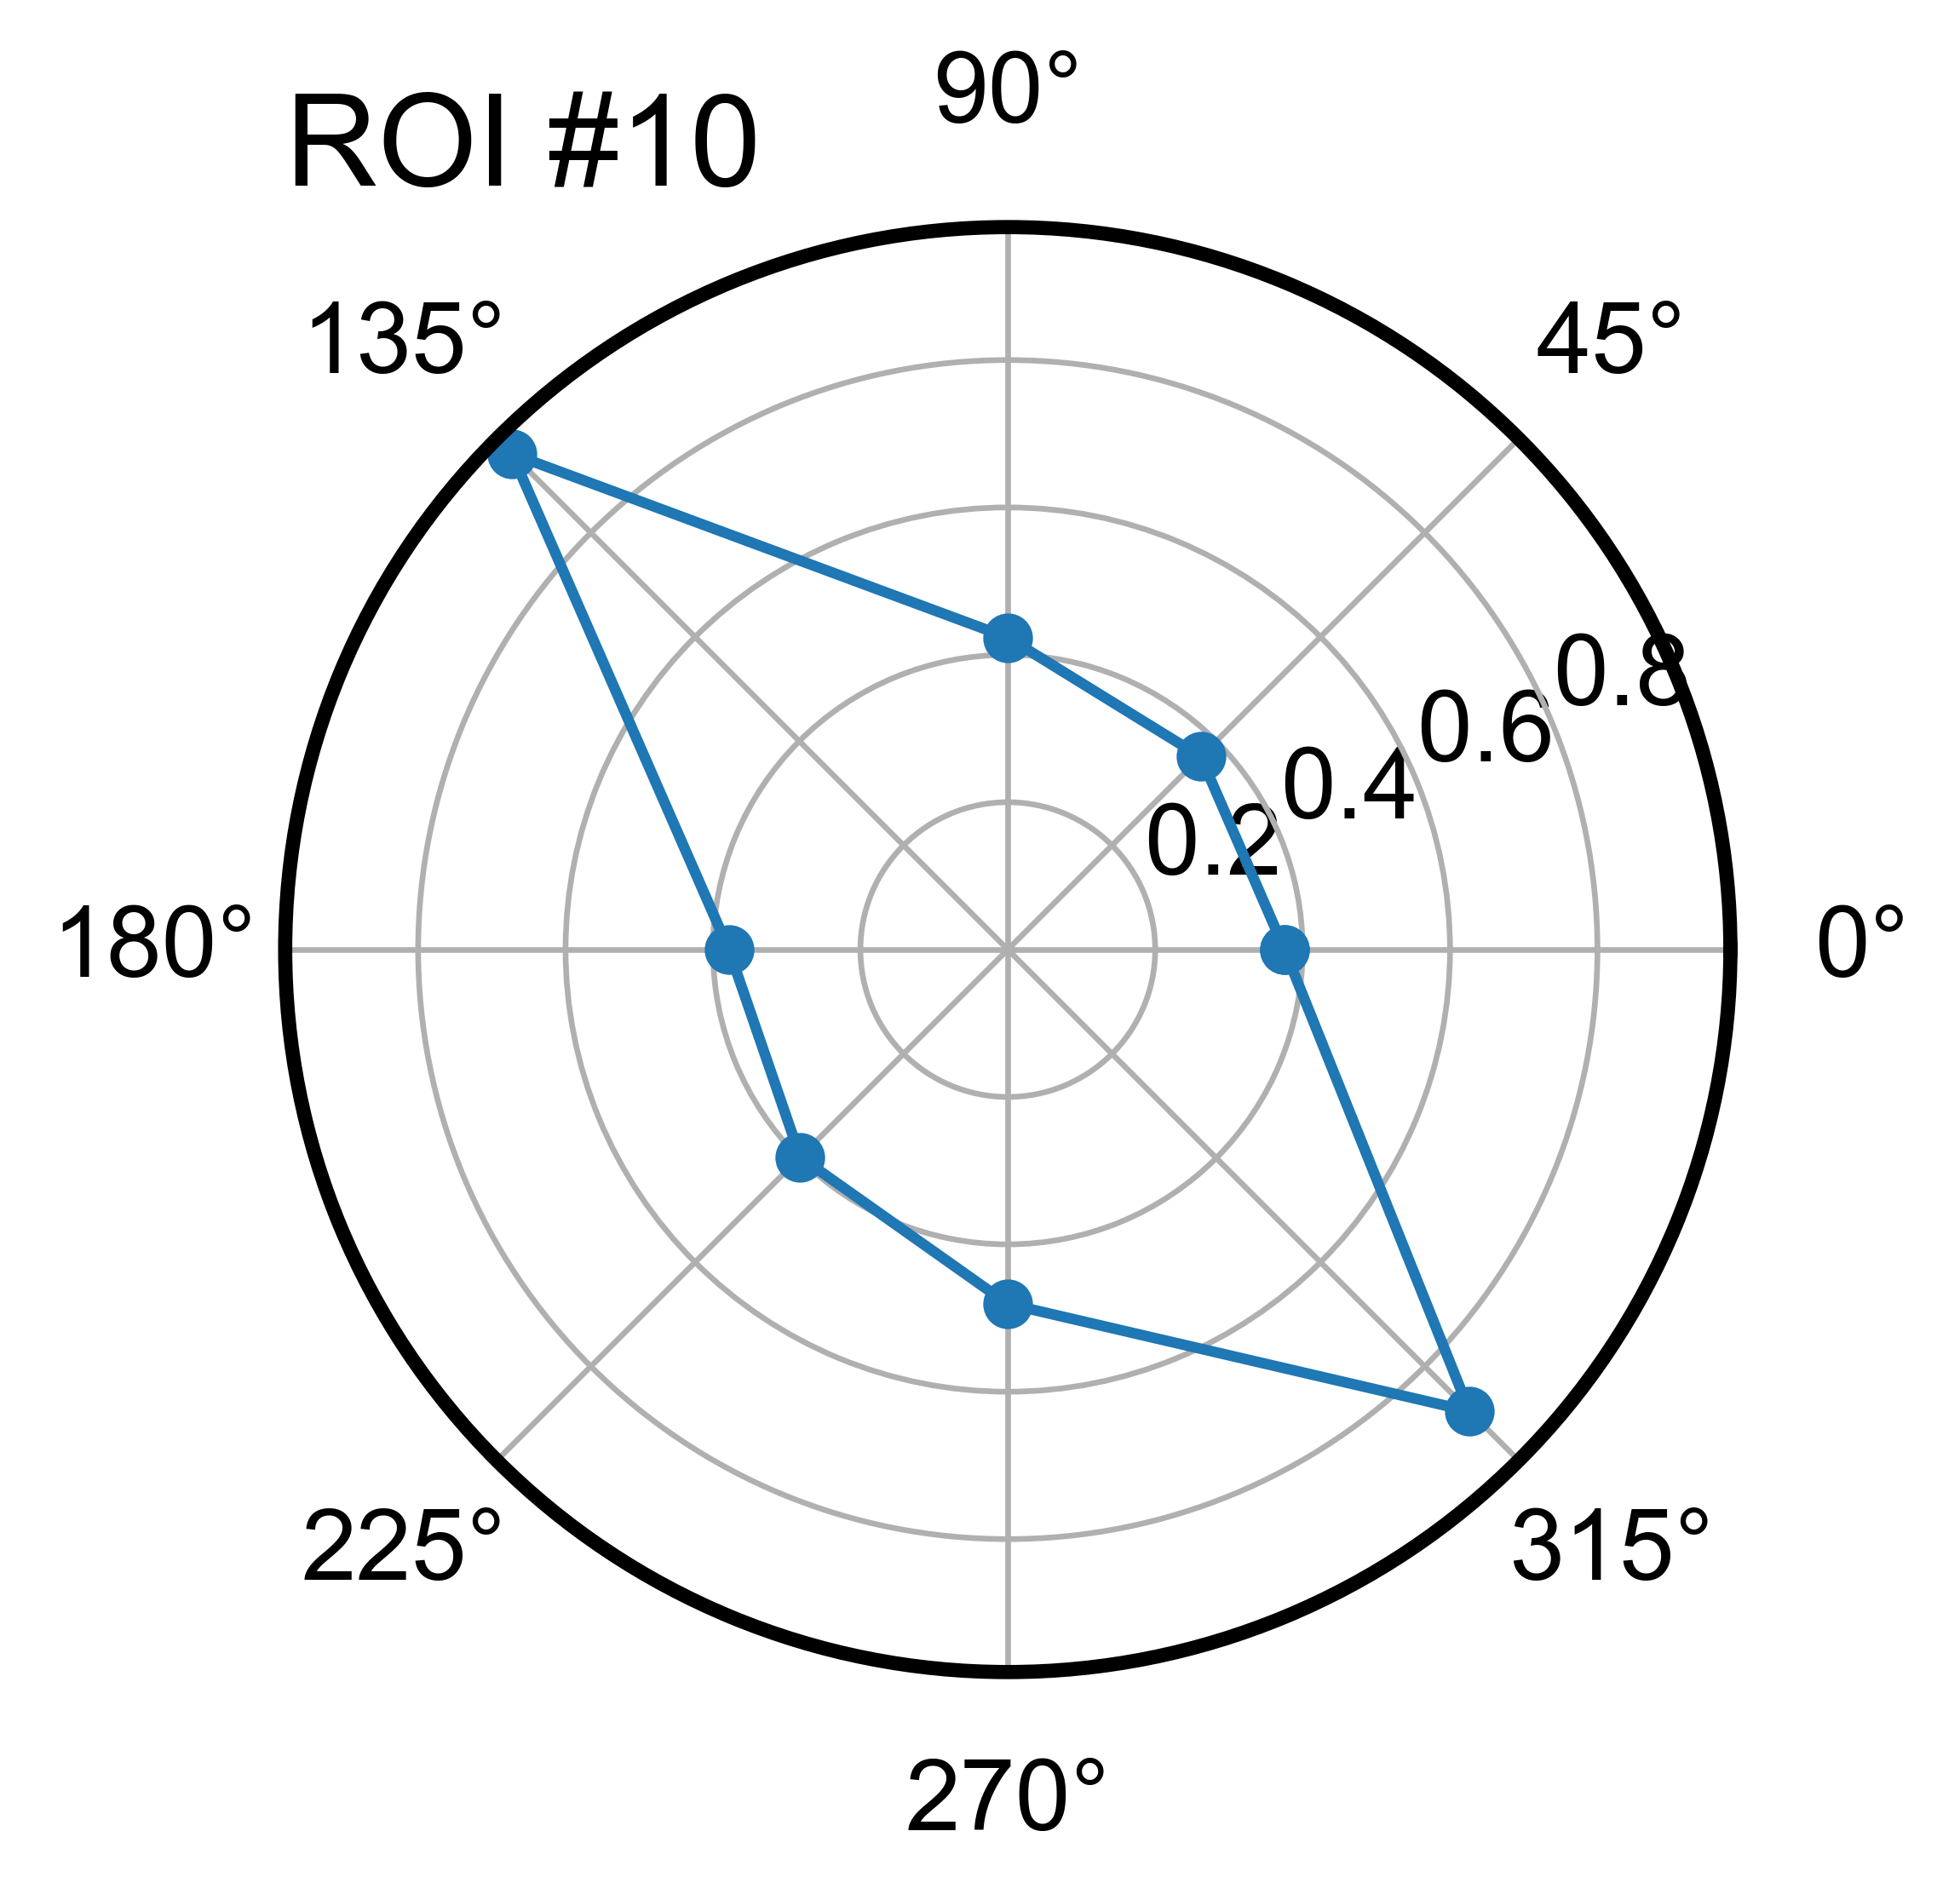

In [93]:
## PLOT POLAR PLOT
def plot_tuning_curve(angles, responses):
    """
    Plot tuning curve with polar plot.
    
    Args:
      angles    : array-like of angles in degrees
      responses : array-like of responses (same length as angles)
    """
    import matplotlib.pyplot as plt
    import numpy as np

    angles = np.asarray(angles)
    responses = np.asarray(responses)
    angles_rad = np.deg2rad(angles)

    if angles_rad.size:
        closed_angles = np.append(angles_rad, angles_rad[0])
        closed_responses = np.append(responses, responses[0])
    else:
        closed_angles = angles_rad
        closed_responses = responses
    
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(closed_angles, closed_responses, marker='o', linestyle='-')
    
    ax.set_theta_zero_location('E')  # 0° on the right
    ax.set_theta_direction(1)         # increase counter-clockwise
    
    ax.set_xticks(np.deg2rad(np.arange(0, 360, 45)))
    ax.set_xticklabels([f'{i}°' for i in range(0, 360, 45)])
    
    ax.set_title(f"ROI #{roi_id}", loc= 'left')
    
    plt.tight_layout()
    plt.show()

plot_tuning_curve(pref_on.dir.dir_mean.index, pref_on.dir.dir_mean.values)

In [90]:
# CALCULATE TUNING, OSI, DSI FOR ALL ROIS IN SELECTED SESSION
cell_flags = database.raw.cell_identifier.loc[subject, session][:, 0].astype(bool)
shared_len = min(cell_flags.shape[0], dff_on.shape[0])
valid_indices = np.flatnonzero(cell_flags[:shared_len])
roi_metrics = []
for roi_idx in range(shared_len):
    roi_on_means = mean_dff_per_trial(dff_on, roi_idx)
    tuning = preferred_stimulus(roi_on_means)
    try:
        norm_vals = normalize_tuning(tuning)
    except Exception as exc:
        print(f"Warning: normalize_tuning failed for ROI {roi_idx}: {exc}")
        norm_vals = {'norm_ori': np.nan, 'norm_dir': np.nan, 'osi': np.nan, 'dsi': np.nan}
    try:
        osi_vals = osi_dsi(tuning)
    except Exception as exc:
        print(f"Warning: osi_dsi failed for ROI {roi_idx}: {exc}")
        osi_vals = {'osi': np.nan, 'dsi': np.nan}
    roi_metrics.append({
        'roi_id': roi_idx,
        'preferred_orientation': tuning['ori']['pref_ori'],
        'preferred_direction': tuning['dir']['pref_dir'],
        'norm_orientation_tuning': norm_vals.get('norm_ori', np.nan),
        'norm_direction_tuning': norm_vals.get('norm_dir', np.nan),
        'osi': osi_vals.get('osi', np.nan),
        'dsi': osi_vals.get('dsi', np.nan),
        'orientation_mean_map': tuning['ori']['ori_mean'].to_dict(),
        'direction_mean_map': tuning['dir']['dir_mean'].to_dict()
    })
roi_metrics_df = pd.DataFrame(roi_metrics).set_index('roi_id')
roi_metrics_df

IndexError: index 108 is out of bounds for axis 0 with size 108

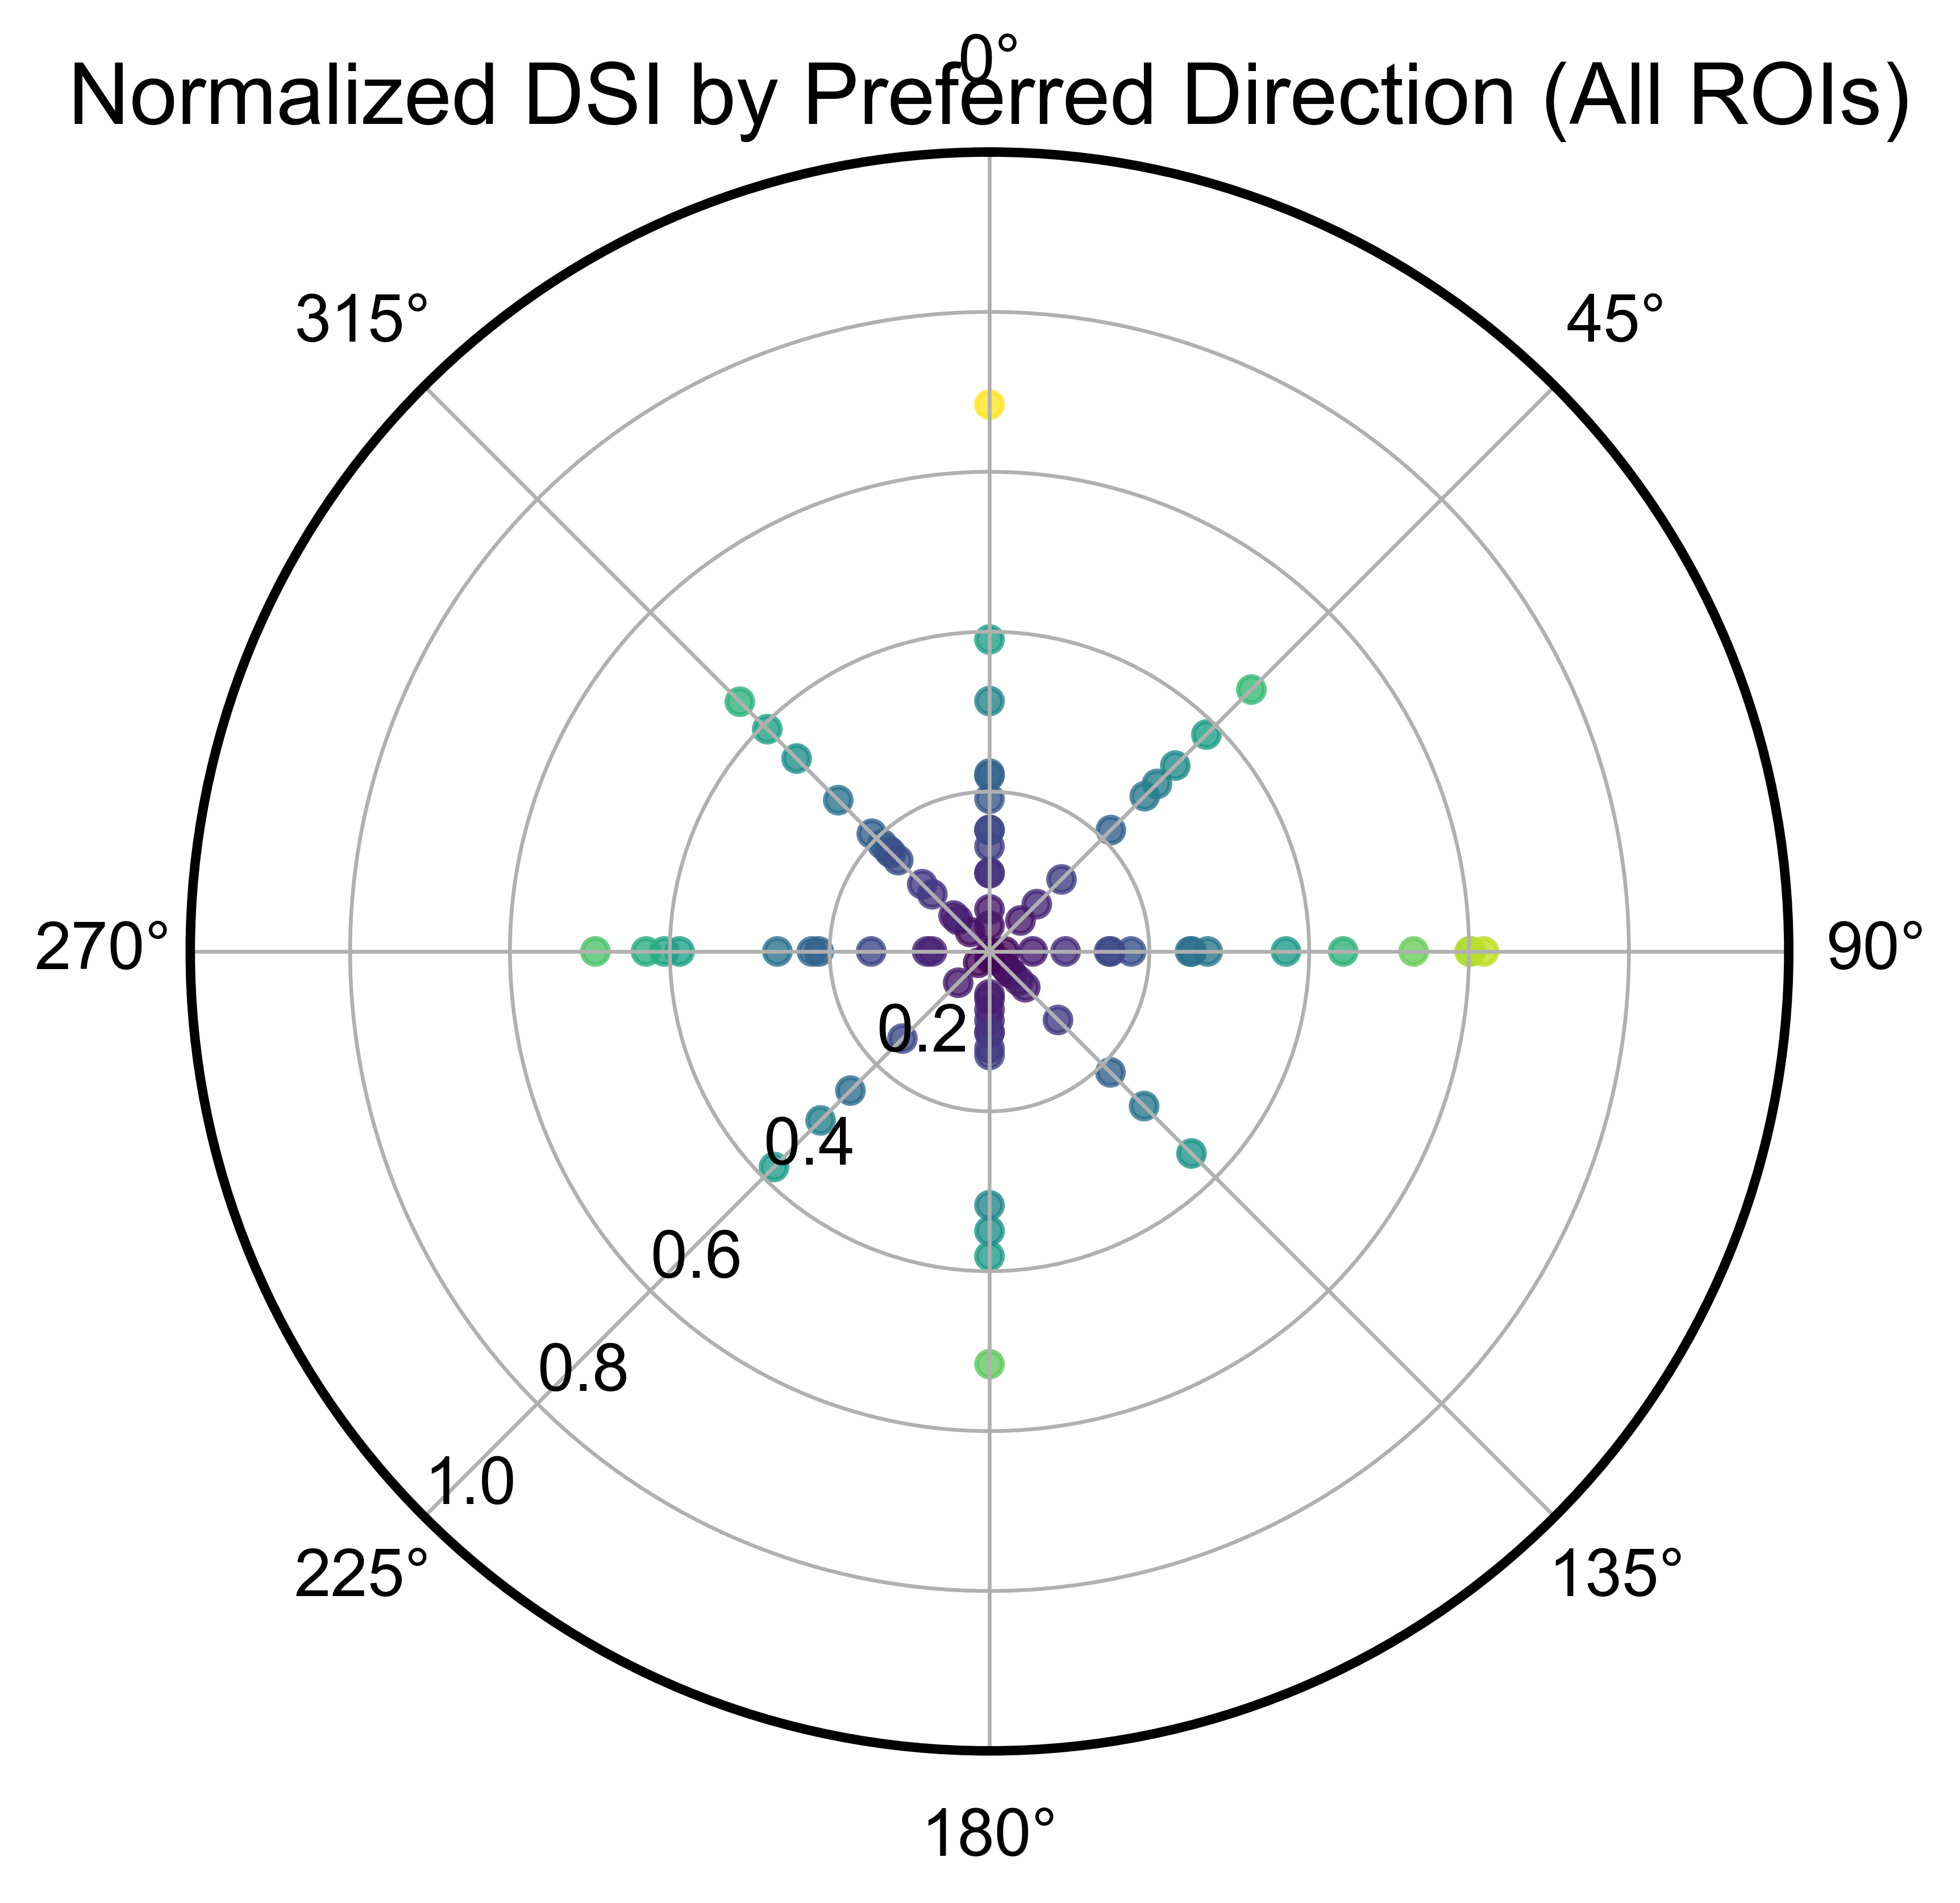

In [88]:
# PLOT POLAR PLOT OF NORMALIZED DSI FOR PREFERRED DIRECTION FOR ALL ROIS
def plot_population_dsi_polar(roi_metrics_df):
    """Plot each ROI's normalized DSI at its preferred direction on a single polar chart."""
    if roi_metrics_df.empty:
        raise ValueError("roi_metrics_df is empty; run the tuning calculation cell first.")
    angles = []
    magnitudes = []
    for roi_id, row in roi_metrics_df.iterrows():
        pref_dir = row['preferred_direction']
        norm_val = row['norm_direction_tuning']
        if pd.isna(pref_dir) or pd.isna(norm_val):
            continue
        angle_rad = np.deg2rad(pref_dir)
        angles.append(angle_rad)
        magnitudes.append(norm_val)
    if not angles:
        raise ValueError("No ROIs with valid preferred direction and normalized tuning values.")
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
    ax.scatter(angles, magnitudes, c=magnitudes, cmap='viridis', s=30, alpha=0.8)
    ax.set_title('Normalized DSI by Preferred Direction (All ROIs)')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(225)
    ax.set_ylim(0, max(1.0, max(magnitudes)))
    plt.tight_layout()
    plt.show()

plot_population_dsi_polar(roi_metrics_df)